In [76]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
import pandas as pd
from scipy.integrate import solve_ivp
import random as rd
import scipy as sp

In [133]:
class Particle:
    #single particle
    def __init__(self):
        self.x0 = rd.random()
        self.y0 = rd.random()
        
        self.xf = rd.random()
        self.yf = rd.random()
        
        l = np.sqrt((self.xf-self.x0)**2 + (self.yf-self.y0)**2)
        
        #define inertia
        self.m = 1;
        
        #define max speed, force
        self.vmax = 1.3*l; #allows it to go 25% extra distance
        self.Fmax = 1;
        
    
    def __str__(self):
        return ('From ({0:2.2f},{1:2.2f}) to ({2:2.2f},{3:2.2f})'.format(self.x0,self.y0, self.xf,self.yf))

    def plot_direct_traj(self):
        plt.plot([self.x0,self.xf],[self.y0,self.yf],'--',lw=0.5)
        plt.plot([self.x0],[self.y0],'o',c='g')
        
    def get_num_states_and_controls(self):
        return (2,2)
    
    def dynamics(self,state,controls):

        x = state[0]
        y = state[1]
        
        vx = controls[0]
        vy = controls[1]
        
        return (vx, vy)
    
    def initial_guess_state(self,n):
        #n is the number of nodes
        
        x = np.linspace(self.x0, self.xf, n)
        y = np.linspace(self.y0, self.yf, n)
        
        return (x,y)
    
    def initial_guess_control(self,n):
        #n is the number of nodes
        
        #guess is a linear path of constant, max velocity between the points
        delx = self.xf-self.x0
        dely = self.yf-self.y0
        l = np.sqrt(delx**2+dely**2)
        
        vx = (self.vmax*delx/l)*np.ones(n)
        vy = (self.vmax*dely/l)*np.ones(n)
        
        return (vx,vy)
        
class Particles:
    #collection of particles
    
    def __init__(self,N=2):
        self.N = N #number of particles
        
        #define max time
        self.tf_max = 1
        
        #define state vector size
        self.len_state = 2
        self.len_control = 2
        
        #generate particles
        self.list_of_particles = [];
        
        for i in range(self.N):
            self.list_of_particles.append(Particle())
    
    def print_particles(self):
        
        #print the details of each particle
        [print(p) for p in self.list_of_particles]
        
        return
    
    def get_num_states_and_controls(self):
        p=self.list_of_particles[0]
        (s,c) = p.get_num_states_and_controls()
        
        return (self.N*s, self.N*c)
    
    def plot_direct_traj(self,new_fig=False):
        #plot all the direct trajectories
        if new_fig:
            plt.figure()
            
        for i in range(self.N):
            self.list_of_particles[i].plot_direct_traj()
            
    def __str__(self):
        return ('Set of {} Particle(s)'.format(self.N))


In [134]:

def dynamics(prob,obj,section):
    
    N = obj.N;
    n_s = obj.len_state
    n_c = obj.len_control
    
    dx = Dynamics(prob, section)
    
    #prob contains state, each particle
    
    #collect all the prob and controls
    for i in range(N):
        
        p = obj.list_of_particles[i]
        
        state_i   = []
        control_i = []
        
        for s in range(n_s):
            state_i.append(prob.states_all_section(n_s*i+s))
        for c in range(n_c):
            control_i.append(prob.controls_all_section(n_c*i+c))
    
        dyn_i = p.dynamics(state_i,control_i)
        
        for s in range(n_s):
            dx[i*n_s+s] = dyn_i[s]
    
    return dx()

def equality(prob, obj):
    
    N_p = obj.N #number of particles
    n_s = obj.len_state
    n_c = obj.len_control
    
    result = Condition()
    
    #import start and end point conditions
    for i, p in enumerate(obj.list_of_particles):
        x = prob.states_all_section(i*n_s)
        y = prob.states_all_section(i*n_s + 1)
        
        result.equal(x[0],  p.x0)
        result.equal(x[-1], p.xf)
        result.equal(y[0],  p.y0)
        result.equal(y[-1], p.yf)
    
    
    return result()

def inequality(prob, obj):
    
    N_p = obj.N #number of particles
    n_s = obj.len_state
    n_c = obj.len_control
    tf  = prob.time_final(-1)
    
    result = Condition()
    
    #final time must be smaller than some limit
    result.upper_bound(tf, obj.tf_max)
    
    #all the velocities must be less than the respective vmax
    for i, p in enumerate(obj.list_of_particles):
        vx = prob.controls_all_section(i*n_c)
        vy = prob.controls_all_section(i*n_c + 1)
        
        result.upper_bound(vx**2 + vy**2, p.vmax**2)
    
    return result()



def cost(prob, obj):
    return 0.0
    
def running_cost(prob,obj):
    N_p = obj.N #number of particles
    n_s = 2
    n_c = 2
    
    #since i know what the structure is, im gonna cheat and type the equation directly
    cost = 0.0

    for i in range(N_p):
        xi = prob.states_all_section(i*n_s)
        yi = prob.states_all_section(i*n_s + 1)
        for j in range (N_p):
            if i < j:
                xj = prob.states_all_section(j*n_s)
                yj = prob.states_all_section(j*n_s + 1)
                
                cost = cost + np.sum((xi-xj)**(-2)) + np.sum((yi-yj)**(-2))
    
    #no cost on the controls
    
    return cost/10000
    

In [135]:
plt.ion()

#create set of particles
N_p = 5 #number of particles
obj = Particles(N=N_p)

# Program Starting Point
time_init = [0.0, 1.0]

#nodes
N_n = 10 #number of nodes
n = [N_n]

#number of states and controls
n_si = obj.len_state #inidividual number of states and controls
n_ci = obj.len_control
(n_s, n_c) = obj.get_num_states_and_controls() #for the entire problem
num_states = [n_s]
num_controls = [n_c]

#max iterations
max_iteration = 15

prob = Problem(time_init, n, num_states, num_controls, max_iteration)
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
prob.running_cost = running_cost
# prob.cost_derivative = cost_derivative
prob.equality = equality
prob.inequality = inequality


In [136]:
prob

---- parameter ----
nodes = [10]
number of states    = [10]
number of controls  = [10]
number of sections  = 1
number of variables = 201
---- algorithm ----
max iteration = 15
---- function  ----
dynamics        = [<function dynamics at 0x10febb400>]
cost            = <function cost at 0x18298586a8>
cost_derivative = None
equality        = <function equality at 0x1829858378>
inequality      = <function inequality at 0x1829858598>
knot_states_smooth = [<function dynamics at 0x10febb400>]

In [137]:
#define initial guess
particle_list = obj.list_of_particles
for i in range(N_p):
    state    = particle_list[i].initial_guess_state(N_n)
    controls = particle_list[i].initial_guess_control(N_n)
    
    for s in range(n_si):
        prob.set_states_all_section(i*n_si+s, state[s])
        
    for c in range(n_ci):
        prob.set_controls_all_section(i*n_ci+c, controls[c])
        


In [138]:
prob

---- parameter ----
nodes = [10]
number of states    = [10]
number of controls  = [10]
number of sections  = 1
number of variables = 201
---- algorithm ----
max iteration = 15
---- function  ----
dynamics        = [<function dynamics at 0x10febb400>]
cost            = <function cost at 0x18298586a8>
cost_derivative = None
equality        = <function equality at 0x1829858378>
inequality      = <function inequality at 0x1829858598>
knot_states_smooth = [<function dynamics at 0x10febb400>]

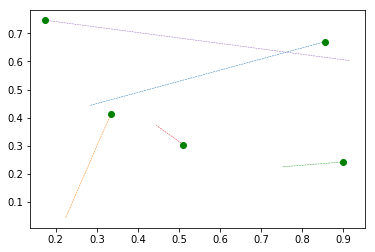

In [139]:
obj.plot_direct_traj()

In [140]:
def display_func(): 
    tf = prob.time_final(-1)
    print("final time  : {0:.3f}".format(tf))

    
import time
start = time.time()    
#solve the problem
prob.solve(obj, display_func, ftol=1e-5)
end = time.time()
print('time taken: ',end - start)


---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 28.80951435331945
            Iterations: 26
            Function evaluations: 5309
            Gradient evaluations: 26
Iteration limit exceeded
final time  : 1.000

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 137.6814320705453
            Iterations: 26
            Function evaluations: 5334
            Gradient evaluations: 26
Iteration limit exceeded
final time  : 1.000

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: 423.6491611582865
            Iterations: 26
            Function evaluations: 5353
            Gradient evaluations: 26
Iteration limit exceeded
final time  : 1.000

---- iteration : 4 ----
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 385.7551145110489
            Iterations: 19
            Function eva

In [141]:
obj.print_particles()

From (0.86,0.67) to (0.28,0.44)
From (0.33,0.41) to (0.22,0.04)
From (0.90,0.24) to (0.75,0.23)
From (0.51,0.30) to (0.44,0.37)
From (0.17,0.75) to (0.92,0.60)


In [142]:
prob.states_all_section(0)

array([0.85512576, 0.82629035, 0.77187504, 0.70409272, 0.6050073 ,
       0.53518877, 0.44225788, 0.35363646, 0.31025438, 0.28428066])

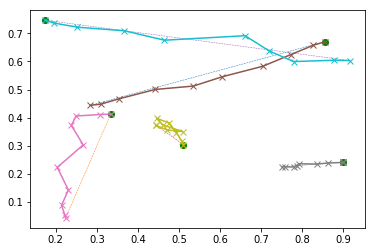

In [148]:
N_p = obj.N

obj.plot_direct_traj()
for i in range(N_p):
    plt.plot(prob.states_all_section(2*i),prob.states_all_section(2*i+1),'-x')

In [149]:
new_time = prob.time_update()

In [150]:
fine_time = np.linspace(0,new_time[-1])

xf=[sp.interpolate.interp1d(new_time,prob.states_all_section(2*i),kind='cubic') for i in range(N_p)]
yf=[sp.interpolate.interp1d(new_time,prob.states_all_section(2*i+1),kind='cubic') for i in range(N_p)]

xfine=[xf_i(fine_time) for xf_i in xf]
yfine=[yf_i(fine_time) for yf_i in yf]

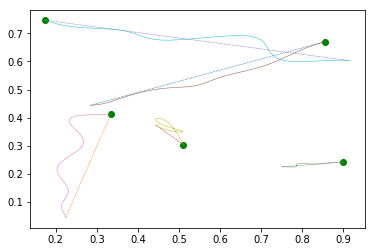

In [146]:
obj.plot_direct_traj()
for i in range(N_p):
    plt.plot(xfine[i],yfine[i],lw=0.5)

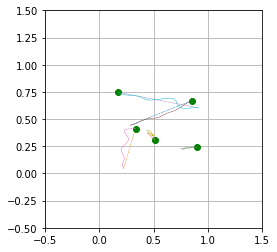

In [147]:
import matplotlib.animation as animation
fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-0.5, 1.5), ylim=(-0.5, 1.5))
ax.set_aspect('equal')
ax.grid()

#plot base image
obj.plot_direct_traj()
for i in range(N_p):
    plt.plot(xfine[i],yfine[i],lw=0.5)

    
#create animation object
line, = ax.plot([], [], 'o',c='k', lw=2)
time_template = 'time = %.2fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(t):
    
    xs = [xfine[i][t] for i in range(N_p)]
    ys = [yfine[i][t] for i in range(N_p)]

    line.set_data(xs, ys)
    
    time_text.set_text(time_template % (fine_time[t]))
    return line, time_text


ani = animation.FuncAnimation(fig, animate, frames=np.arange(0, len(fine_time)),
                              interval=50, blit=False, init_func=init,repeat_delay=1000)

ani.save('line.gif', dpi=150, writer='imagemagick')
#plt.show()